## Предсказание количества звонков в колл-центр в городе Окленд с помощью Prophet

Данные: https://www.kaggle.com/datasets/cityofoakland/oakland-call-center-public-work-service-requests?resource=download

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as date
import holidays
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [3]:
df = pd.read_csv('archive/service-requests-received-by-the-oakland-call-center.csv', low_memory=False)

In [4]:
df.head(3)

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,REQADDRESS,STATUS,REFERREDTO,DATETIMECLOSED,SRX,SRY,COUNCILDISTRICT,BEAT,PROBADDRESS,City,State,Zip Codes
0,967630,2019-12-05T23:43:57.000,SeeClickFix,Other City Services (app/web request),OTHER,"{'latitude': '37.74001952157057', 'longitude':...",PENDING,NaN,NaN,6074553.652,2096304.375,CCD7,31Y,9331 RAILROAD AVE,Oakland,CA,1481.0
1,967629,2019-12-05T22:47:13.000,SeeClickFix,Parking - Enforcement,PARKING,"{'latitude': '37.80597222181423', 'longitude':...",PENDING,NaN,NaN,6072533.550,2120359.518,CCD4,22Y,3174-3198 MONTEREY BLVD,Oakland,CA,1480.0
2,967628,2019-12-05T22:35:09.000,SeeClickFix,Parking - Abandoned Vehicle,POLICE,"{'latitude': '37.83247782111242', 'longitude':...",PENDING,NaN,NaN,6052080.284,2130390.392,CCD1,12X,528 44TH ST,Oakland,CA,1486.0


In [5]:
df['SOURCE'].unique()

array(['SeeClickFix', 'Phone or Email', 'Phone', 'Voicemail', 'Email',
       'Other', 'Website', 'City Attorney'], dtype=object)

В датафреме присутствуют обращения из разных источников, нас будут интересовать только телефонные звонки

In [6]:
df['DATETIMEINIT'] = pd.to_datetime(df['DATETIMEINIT'])
df['DATETIMEROUND'] = df['DATETIMEINIT'].dt.floor('d')

In [12]:
calls = df[df['SOURCE']=='Phone'].groupby(by='DATETIMEROUND', as_index=False).size()
calls.rename(columns={'DATETIMEROUND':'ds', 'size':'y'}, inplace=True)
calls.isna().any() # наличие пропусков

ds    False
y     False
dtype: bool

Визуализиурем временной ряд

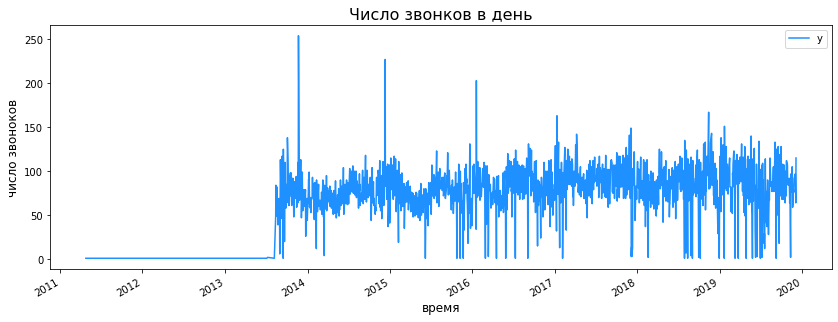

In [8]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
calls.plot(kind='line', x='ds', y='y', color='dodgerblue', ax=ax)
plt.title('Число звонков в день', size=16)
plt.xlabel('время', size=12)
plt.ylabel('число звоноков', size=12)
plt.show()

В датах выходных дней имеются пропуски, мы учтем это в дальнейшем.

Данные по звонкам до 2015 года либо отсутствуют либо недостаточны, удалим их. Также прологарифмируем временной ряд.

In [15]:
calls = calls[calls.ds.dt.year >= 2015]

In [13]:
calls.y = np.log(calls.y)

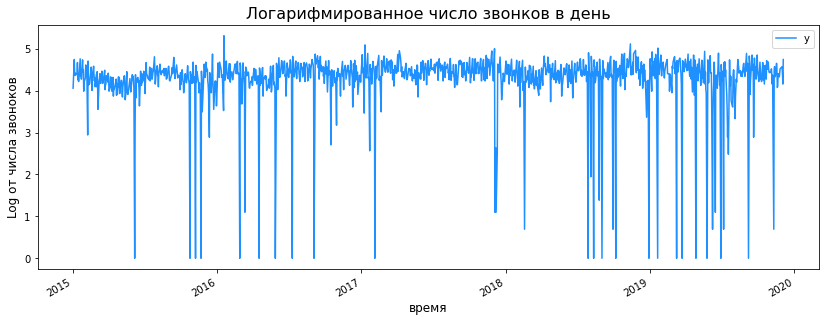

In [16]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
calls.plot(kind='line', x='ds', y='y', color='dodgerblue', ax=ax)
plt.title('Логарифмированное число звонков в день', size=16)
plt.xlabel('время', size=12)
plt.ylabel('Log от числа звоноков', size=12)
plt.show()

Обучим модель без параметров и рассмотрим разложение временного ряда на компоненты

In [17]:
model = Prophet()
model.fit(calls)

16:26:49 - cmdstanpy - INFO - Chain [1] start processing
16:26:49 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)

Визуализиуем компоненты

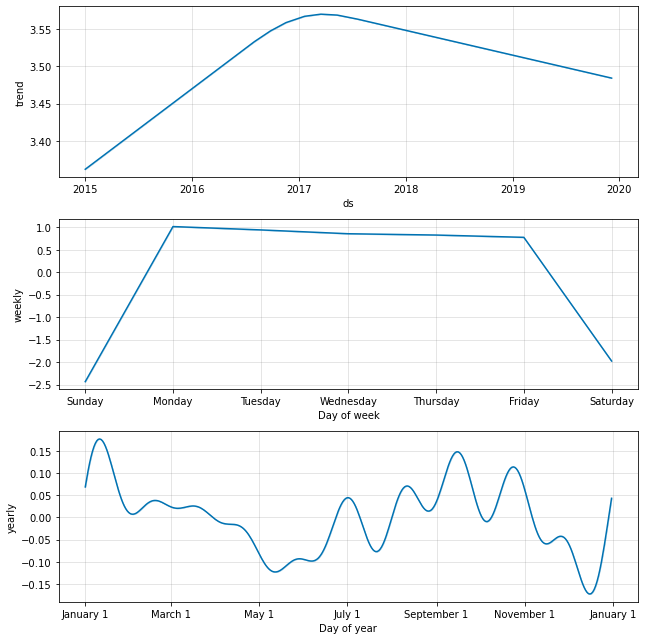

In [19]:
model.plot_components(forecast);

Оценим модель методом кросс-валидации

In [20]:
df_cv = cross_validation(model, horizon = '365 days', parallel='processes')

In [21]:
df_p = performance_metrics(df_cv, rolling_window = 0.1)
df_p.mean()

horizon     200 days 03:04:32.268907564
mse                            0.319019
rmse                           0.527902
mae                             0.30137
mdape                          0.043052
smape                          0.133481
coverage                       0.862031
dtype: object

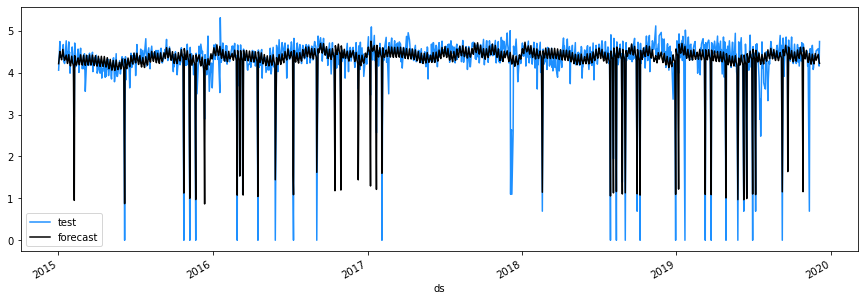

In [22]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
calls.plot(kind='line',x='ds', y='y', color='dodgerblue', label='test', ax=ax)
forecast.plot(kind='line',x='ds',y='yhat', color='black',label='forecast', ax=ax)
plt.show()

Разделим датасет на тренировочную и тестовую выборки. Попробуем предсказать один месяц.

In [23]:
train = calls[:-30].copy()
test = calls[-30:].copy()
train.shape, test.shape

((1246, 2), (30, 2))

Учтем праздники в штате Калифорния и предскажем количество обращений

In [24]:
years = list(range(2009, 2020, 1))

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=years, subdiv="CA").items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "CA-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [25]:
model = Prophet(holidays=holiday, daily_seasonality=False)
model.fit(train)

16:27:12 - cmdstanpy - INFO - Chain [1] start processing
16:27:12 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
print(model.changepoint_prior_scale, model.seasonality_prior_scale, model.holidays_prior_scale)

0.05 10.0 10.0


In [27]:
future = model.make_future_dataframe(periods=42, freq='D')
future = future[future['ds'].dt.dayofweek < 5] # не будем предсказывать выходные т.к. нет данных

forecast = model.predict(future)

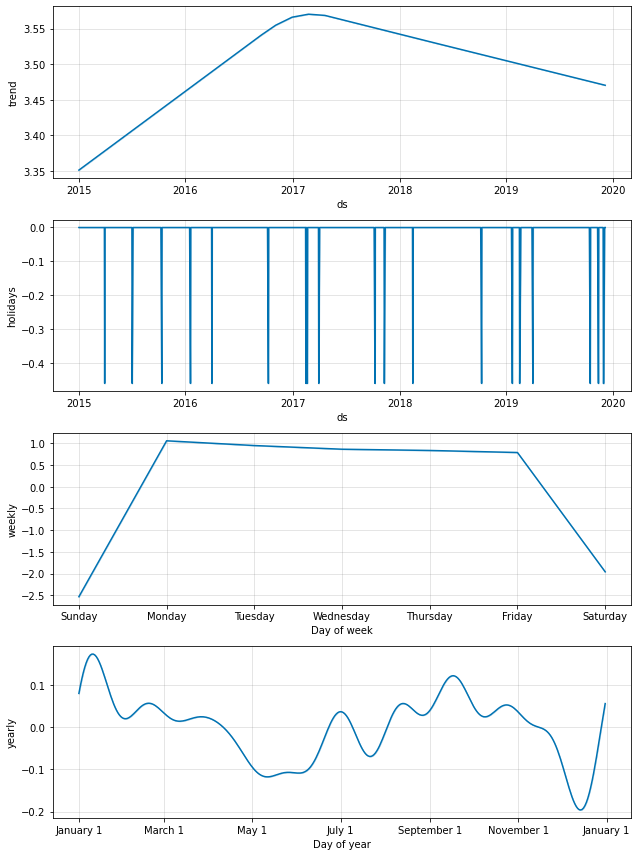

In [28]:
model.plot_components(forecast);

In [29]:
df_cv = cross_validation(model, horizon = '365 days', parallel='processes')

In [30]:
df_p = performance_metrics(df_cv, rolling_window = 0.1)
df_p.mean()

horizon     201 days 17:53:53.898305084
mse                            0.280862
rmse                           0.503513
mae                            0.346725
mdape                           0.06134
smape                          0.140348
coverage                       0.781169
dtype: object

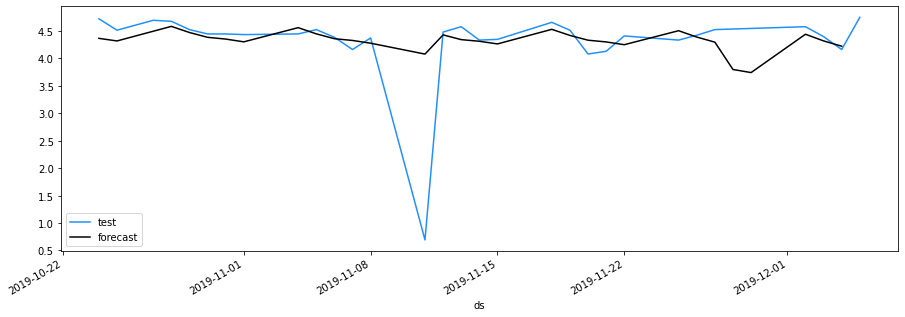

In [31]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(kind='line',x='ds', y='y', color='dodgerblue', label='test', ax=ax)
forecast[-30:].plot(kind='line',x='ds',y='yhat', color='black',label='forecast', ax=ax)
plt.show()

### Переберем гиперпараметры 

In [36]:
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.03, 0.05], 
    'seasonality_prior_scale': [3.0, 5.0, 7.0, 10.0], 
}

# Создаем все комбинации параметров
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  
mdapes = []

# Крутим кроссвалидацию со всеми комбинациями параметров
for params in all_params:
    m = Prophet(**params, weekly_seasonality=True, yearly_seasonality=True, holidays=holiday)  
    m.fit(train)
    df_cv = cross_validation(m, horizon = '365 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1) 
    maes.append(df_p['mae'].values[0])
    mdapes.append(df_p['mdape'].values[0])

# Смотрим на результаты с разными параметрами
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mdape'] = mdapes

16:29:05 - cmdstanpy - INFO - Chain [1] start processing
16:29:05 - cmdstanpy - INFO - Chain [1] done processing
16:29:10 - cmdstanpy - INFO - Chain [1] start processing
16:29:10 - cmdstanpy - INFO - Chain [1] done processing
16:29:15 - cmdstanpy - INFO - Chain [1] start processing
16:29:16 - cmdstanpy - INFO - Chain [1] done processing
16:29:21 - cmdstanpy - INFO - Chain [1] start processing
16:29:21 - cmdstanpy - INFO - Chain [1] done processing
16:29:26 - cmdstanpy - INFO - Chain [1] start processing
16:29:26 - cmdstanpy - INFO - Chain [1] done processing
16:29:31 - cmdstanpy - INFO - Chain [1] start processing
16:29:31 - cmdstanpy - INFO - Chain [1] done processing
16:29:36 - cmdstanpy - INFO - Chain [1] start processing
16:29:36 - cmdstanpy - INFO - Chain [1] done processing
16:29:41 - cmdstanpy - INFO - Chain [1] start processing
16:29:41 - cmdstanpy - INFO - Chain [1] done processing
16:29:46 - cmdstanpy - INFO - Chain [1] start processing
16:29:46 - cmdstanpy - INFO - Chain [1]

In [37]:
tuning_results.sort_values(by=['mae','mdape']).head(3)

,changepoint_prior_scale,seasonality_prior_scale,mae,mdape
0,0.01,3.0,0.267979,0.038073
1,0.01,5.0,0.268625,0.037949
2,0.01,7.0,0.269411,0.038631


Обучим модель на полученных параметрах

In [38]:
model = Prophet(holidays=holiday, changepoint_prior_scale=0.01, seasonality_prior_scale=3.0)
model.fit(train)

16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
future = model.make_future_dataframe(periods=42, freq='D')
future = future[future['ds'].dt.dayofweek < 5] # не будем предсказывать выходные т.к. нет данных

forecast = model.predict(future)

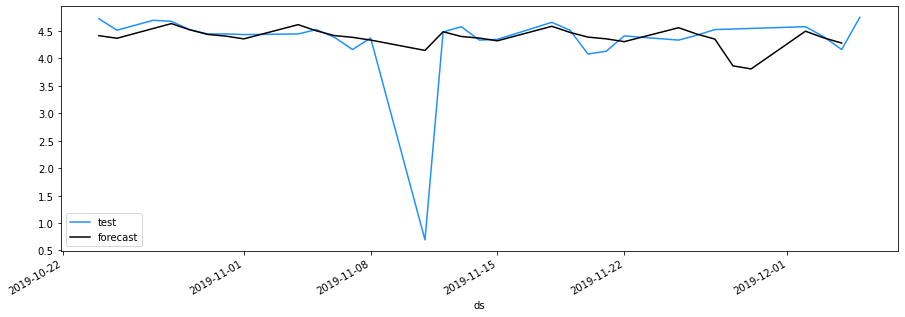

In [40]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(kind='line',x='ds', y='y', color='dodgerblue', label='test', ax=ax)
forecast[-30:].plot(kind='line',x='ds',y='yhat', color='black',label='forecast', ax=ax)
plt.show()